In [1]:
#Importing the necessary libraries
import pandas as pd
import librosa
import librosa.display
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:

# Paths
csv_path = "data/metadata.csv" 
audio_dir = "data/audio_data"  

# Load CSV and filter for Jeevan
df = pd.read_csv(csv_path)
jeevan_files = df[df["speaker_label"] == "Jeevan"]["filename"].tolist()
print(f"Found {len(jeevan_files)} files for Jeevan: {jeevan_files}")

# Parameters for STFT
sr = 16000  # Sample rate
n_fft = 2048  # Window size
hop_length = 512  # Hop length

# Convert audio files to spectrograms
spectrograms = []
for filename in jeevan_files:
    audio_path = os.path.join(audio_dir, filename)
    audio, _ = librosa.load(audio_path, sr=sr)
    # Compute magnitude spectrogram
    spec = np.abs(librosa.stft(audio, n_fft=n_fft, hop_length=hop_length))
    # Log-scale for better training
    spec = librosa.amplitude_to_db(spec, ref=np.max)
    # Pad or truncate to a fixed length (e.g., 128 frames) for consistency
    if spec.shape[1] > 128:
        spec = spec[:, :128]
    else:
        spec = np.pad(spec, ((0, 0), (0, 128 - spec.shape[1])), mode="constant")
    spectrograms.append(spec)

# Convert to numpy array: (num_samples, freq_bins, time_frames)
spectrograms = np.array(spectrograms)  # Shape: (N, 1025, 128)
print(f"Spectrogram shape: {spectrograms.shape}")

# Normalize to [0, 1] for model training
spec_min, spec_max = spectrograms.min(), spectrograms.max()
spectrograms = (spectrograms - spec_min) / (spec_max - spec_min)

Found 418 files for Jeevan: ['Debate with Dobby (1)_segment_1.wav', 'Debate with Dobby (1)_segment_10.wav', 'Debate with Dobby (1)_segment_11.wav', 'Debate with Dobby (1)_segment_12.wav', 'Debate with Dobby (1)_segment_13.wav', 'Debate with Dobby (1)_segment_14.wav', 'Debate with Dobby (1)_segment_15.wav', 'Debate with Dobby (1)_segment_16.wav', 'Debate with Dobby (1)_segment_17.wav', 'Debate with Dobby (1)_segment_18.wav', 'Debate with Dobby (1)_segment_19.wav', 'Debate with Dobby (1)_segment_2.wav', 'Debate with Dobby (1)_segment_20.wav', 'Debate with Dobby (1)_segment_21.wav', 'Debate with Dobby (1)_segment_22.wav', 'Debate with Dobby (1)_segment_3.wav', 'Debate with Dobby (1)_segment_4.wav', 'Debate with Dobby (1)_segment_5.wav', 'Debate with Dobby (1)_segment_6.wav', 'Debate with Dobby (1)_segment_7.wav', 'Debate with Dobby (1)_segment_8.wav', 'Debate with Dobby (1)_segment_9.wav', 'EduAccess _ Making Education Accessible for All_segment_1.wav', 'EduAccess _ Making Education Acces

## Spectrogram Generator

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import time

# Maximize CPU threads (still useful if MPS fails)
torch.set_num_threads(8)

# Suppress torch.compile errors
torch._dynamo.config.suppress_errors = True

# Define VAE model (unchanged)
class VAE(nn.Module):
    def __init__(self, input_channels=1, freq_bins=1025, time_frames=128):
        super(VAE, self).__init__()
        self.freq_bins = freq_bins
        self.time_frames = time_frames
        self.input_channels = input_channels
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU()
        )
        self._initialize_shapes()
        self.fc_mu = nn.Linear(self.flattened_size, 64)
        self.fc_logvar = nn.Linear(self.flattened_size, 64)
        self.decoder_fc = nn.Linear(64, self.flattened_size)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=(0, 1)),
            nn.ReLU(),
            nn.ConvTranspose2d(32, input_channels, 3, stride=2, padding=1, output_padding=(0, 1)),
            nn.Sigmoid()
        )

    def _initialize_shapes(self):
        with torch.no_grad():
            dummy_input = torch.zeros(1, self.input_channels, self.freq_bins, self.time_frames)
            x = self.encoder(dummy_input)
            self.enc_height, self.enc_width = x.shape[2], x.shape[3]
            self.flattened_size = 64 * self.enc_height * self.enc_width

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.decoder_fc(z)
        x = x.view(-1, 64, self.enc_height, self.enc_width)
        x = self.decoder(x)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Loss function
def loss_function(recon_x, x, mu, logvar):
    MSE = nn.functional.mse_loss(recon_x, x, reduction="sum")
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + 0.01 * KLD

# Data setup
spectrograms_tensor = torch.FloatTensor(spectrograms).unsqueeze(1)  # (418, 1, 1025, 128)
dataset = TensorDataset(spectrograms_tensor, spectrograms_tensor)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=4)

# Device setup
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize model and optimizer
model = VAE(freq_bins=1025, time_frames=128).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Compile model (with fallback)
if torch.__version__ >= "2.0":
    try:
        model = torch.compile(model)
        print("Using torch.compile for speedup")
    except Exception as e:
        print(f"torch.compile failed: {e}, falling back to eager execution")
else:
    print("PyTorch < 2.0, skipping torch.compile")

# Move data to device
spectrograms_tensor = spectrograms_tensor.to(device)

# Debugging shapes
print(f"Input shape: {spectrograms_tensor.shape}")
dummy_input = torch.zeros(1, 1, 1025, 128).to(device)
with torch.no_grad():
    recon_x, _, _ = model(dummy_input)
    print(f"Output shape after decoder: {recon_x.shape}")

# Training loop with timing
num_epochs = 20
start_time = time.time()
for epoch in range(num_epochs):
    total_loss = 0
    for batch in dataloader:
        x = batch[0].to(device)
        optimizer.zero_grad()
        recon_x, mu, logvar = model(x)
        loss = loss_function(recon_x, x, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss}")
    if avg_loss < 1500:
        print(f"Loss below 1500, stopping early at epoch {epoch+1}")
        break
print(f"Training took {time.time() - start_time:.2f} seconds")

# Save model
torch.save(model.state_dict(), "vae_model.pth")

Using device: mps
Using torch.compile for speedup
Input shape: torch.Size([418, 1, 1025, 128])


W0309 00:25:23.635000 21833 torch/_dynamo/convert_frame.py:1233] WON'T CONVERT forward /var/folders/cd/vmj840453cz603ygrc6my4300000gn/T/ipykernel_21833/246862781.py line 62 
W0309 00:25:23.635000 21833 torch/_dynamo/convert_frame.py:1233] due to: 
W0309 00:25:23.635000 21833 torch/_dynamo/convert_frame.py:1233] Traceback (most recent call last):
W0309 00:25:23.635000 21833 torch/_dynamo/convert_frame.py:1233]   File "/Users/jeevanbhatta/Downloads/voice-classification/venv/lib/python3.11/site-packages/torch/_dynamo/convert_frame.py", line 1164, in __call__
W0309 00:25:23.635000 21833 torch/_dynamo/convert_frame.py:1233]     result = self._inner_convert(
W0309 00:25:23.635000 21833 torch/_dynamo/convert_frame.py:1233]              ^^^^^^^^^^^^^^^^^^^^
W0309 00:25:23.635000 21833 torch/_dynamo/convert_frame.py:1233]   File "/Users/jeevanbhatta/Downloads/voice-classification/venv/lib/python3.11/site-packages/torch/_dynamo/convert_frame.py", line 547, in __call__
W0309 00:25:23.635000 21833

Output shape after decoder: torch.Size([1, 1, 1025, 128])
Epoch 1/20, Loss: 6661.146103562351
Epoch 2/20, Loss: 4233.583218077153
Epoch 3/20, Loss: 3659.2755938808314
Epoch 4/20, Loss: 3524.92508153596
Epoch 5/20, Loss: 3291.377982837732
Epoch 6/20, Loss: 2942.77233010616
Epoch 7/20, Loss: 2651.7548676267197
Epoch 8/20, Loss: 2450.1601492411783
Epoch 9/20, Loss: 2322.846015017569
Epoch 10/20, Loss: 2169.3974241411856
Epoch 11/20, Loss: 2057.0401062303754
Epoch 12/20, Loss: 1969.3121694172398
Epoch 13/20, Loss: 1896.348173734674
Epoch 14/20, Loss: 1839.6436422977722
Epoch 15/20, Loss: 1793.92022559061
Epoch 16/20, Loss: 1764.9892969450882
Epoch 17/20, Loss: 1727.529632130308
Epoch 18/20, Loss: 1687.2748801491477
Epoch 19/20, Loss: 1647.8628782427481
Epoch 20/20, Loss: 1614.3468706778933
Training took 357.48 seconds


In [14]:
torch.save(model.state_dict(), "vae_model.pth")

## Generating Spectogram

In [15]:
# Load trained model
model = VAE().to(device)
if torch.__version__ >= "2.0":
    try:
        model = torch.compile(model)
        print("Using torch.compile for speedup")
    except Exception as e:
        print(f"torch.compile failed: {e}, proceeding without compilation")
model.load_state_dict(torch.load("vae_model.pth"))
model.eval()
# Generate a spectrogram
with torch.no_grad():
    z = torch.randn(1, 64).to(device)  # Random latent vector, move to device
    generated_spectrogram = model.decode(z).squeeze(0).cpu().numpy()  # Shape: (1, 1025, 128) -> (1025, 128)

# Denormalize to original scale (ensure spec_max, spec_min are defined)
# Replace with actual values if not in scope
spec_min = np.load("spec_min.npy") if 'spec_min' not in globals() else spec_min
spec_max = np.load("spec_max.npy") if 'spec_max' not in globals() else spec_max
generated_spectrogram = generated_spectrogram * (spec_max - spec_min) + spec_min

print("Generated spectrogram shape:", generated_spectrogram.shape)

Using torch.compile for speedup
Generated spectrogram shape: (1, 1025, 128)


Generated spectrogram shape: (1025, 128)


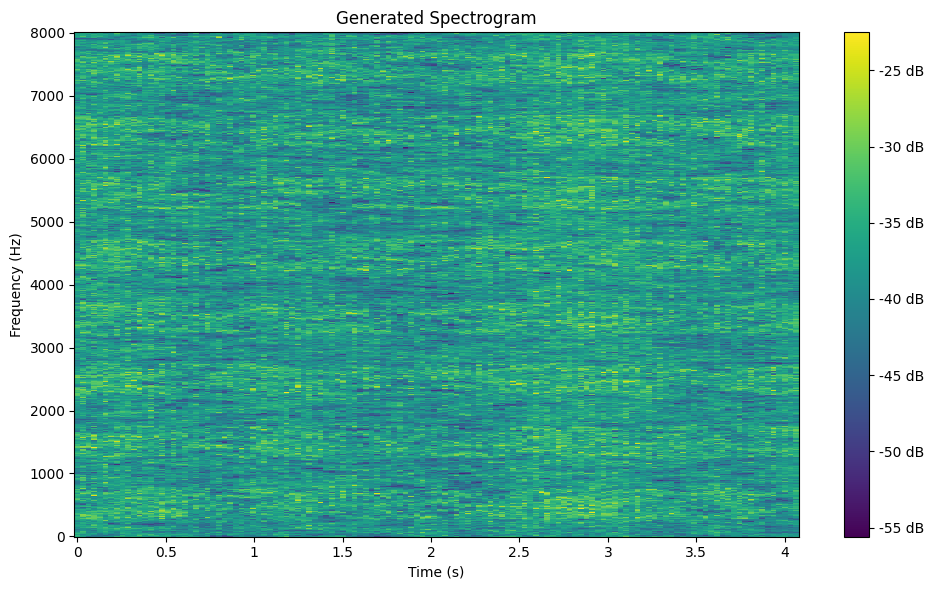

In [6]:
#Visualize the generated spectrogram

import matplotlib.pyplot as plt
import librosa.display
import torch
import numpy as np

# Assuming VAE is defined and loaded (from your earlier code)
# Load trained model
model = VAE().to(device)
state_dict = torch.load("vae_model.pth")
state_dict = {k.replace("_orig_mod.", ""): v for k, v in state_dict.items()}  # Strip _orig_mod if needed
model.load_state_dict(state_dict)
model.eval()

# Generate a spectrogram
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
with torch.no_grad():
    z = torch.randn(1, 64).to(device)
    generated_spectrogram = model.decode(z).squeeze().cpu().numpy()  # Fully squeeze to (1025, 128)

# Denormalize (ensure spec_min, spec_max are defined)
spec_min = np.load("spec_min.npy") if 'spec_min' not in globals() else spec_min
spec_max = np.load("spec_max.npy") if 'spec_max' not in globals() else spec_max
generated_spectrogram = generated_spectrogram * (spec_max - spec_min) + spec_min

# Debug shape
print("Generated spectrogram shape:", generated_spectrogram.shape)

# Visualize the spectrogram
plt.figure(figsize=(10, 6))
librosa.display.specshow(
    generated_spectrogram,
    sr=16000,        # Sample rate
    hop_length=512,  # Hop length
    n_fft=2048,      # FFT window size
    x_axis='time',
    y_axis='hz',
    cmap='viridis'
)
plt.colorbar(format='%+2.0f dB')
plt.title("Generated Spectrogram")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.tight_layout()
plt.show()

## Convert Back to Audio

In [16]:
import soundfile as sf  # Add this import at the top if not already present

# Convert spectrogram to audio
audio = librosa.griffinlim(
    librosa.db_to_amplitude(generated_spectrogram),  # Convert dB back to amplitude
    n_iter=32,
    hop_length=hop_length,
    n_fft=n_fft
)

# Save the audio
sf.write("generated_jeevan_audio.wav", audio, sr)
print("Generated audio saved as 'generated_jeevan_audio.wav'")

LibsndfileError: Error opening 'generated_jeevan_audio.wav': Format not recognised.

In [17]:
# Convert spectrogram to audio
audio = librosa.griffinlim(
    librosa.db_to_amplitude(generated_spectrogram),
    n_iter=50,  # Increased for better phase reconstruction
    hop_length=hop_length,
    n_fft=n_fft
)

# Check and fix the audio shape
print(f"Original audio shape: {audio.shape}")
if len(audio.shape) > 1 and audio.shape[0] == 1:
    # Remove the extra dimension if needed
    audio = audio.squeeze(0)
    print(f"Reshaped to: {audio.shape}")

# Current amplitude is very low - let's increase it
print(f"Before scaling - min: {audio.min()}, max: {audio.max()}")
audio = audio * 0.9 / (np.max(np.abs(audio)) + 1e-8)  # Scale to near -0.9 to 0.9
print(f"After scaling - min: {audio.min()}, max: {audio.max()}")

# Save the audio (with fallbacks)
try:
    sf.write("generated_jeevan_audio.wav", audio, sr)
    print("Generated audio saved with soundfile")
except Exception as e:
    print(f"Soundfile error: {e}, trying scipy instead")
    from scipy.io import wavfile
    wavfile.write("generated_jeevan_audio_scipy.wav", int(sr), (audio * 32767).astype(np.int16))
    print("Generated audio saved with scipy")

Original audio shape: (1, 65024)
Reshaped to: (65024,)
Before scaling - min: -0.0022953401785343885, max: 0.0022072577849030495
After scaling - min: -0.8999961018562317, max: 0.8654592037200928
Generated audio saved with soundfile
